In [1]:
from copy import deepcopy
import os
from wildlifeml.utils.datasets import map_bbox_to_img
from wildlifeml.utils.io import (load_csv,load_json,load_pickle,save_as_json,save_as_csv)
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools

from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix) 

import sys; sys.path.insert(1, 'scripts')
import results_functions as rf

2022-11-25 19:11:00.977138: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
translator_dict = {
    '0': 'empty', 
    '1': 'european_hare',
    '2': 'others',
    '3': 'red_deer',
    '4': 'red_fox',
    '5': 'red_squirrel',
    '6': 'roe_deer',
    '7': 'wild_boar',
}


map_dict = {
    'empty': 'empty', 
    'european_hare':'non_empty',
    'others':'non_empty',
    'red_deer':'non_empty',
    'red_fox':'non_empty',
    'red_squirrel':'non_empty',
    'roe_deer':'non_empty',
    'wild_boar':'non_empty',
}

labels = list(translator_dict.values())
metrics = ['acc', 'prec', 'rec', 'f1']

image_data_dir = '/common/bothmannl/wildlife_images/usecase2/original_images/'
label_path = 'data/labels.csv'
detector_path = 'data/images_megadetector.json'
metadata_path = os.path.join('data/metadata.csv')
df_meta = pd.read_csv(metadata_path)[['orig_name', 'true_class', 'doy', 'hour', 'station', 'station_set']]
df_meta = df_meta.rename(columns={'orig_name':'img_name'})
df_ins = df_meta[df_meta['station_set']=='s1']
df_oos = df_meta[df_meta['station_set']=='s2']

label_dict = {k: v for k, v in load_csv(label_path)}
detector_dict = load_json(detector_path)

# Global

In [3]:
# Relative frequencies of classes in all, ins & oos datasets
df = pd.DataFrame(index=labels)
df['all'] = rf.get_frequencies(df_meta, labels, normalize=True)
df['ins'] = rf.get_frequencies(df_ins, labels, normalize=True)
df['oos'] = rf.get_frequencies(df_oos, labels, normalize=True)
df

,all,ins,oos
empty,0.621436,0.641292,0.601061
european_hare,0.015379,0.019903,0.010738
others,0.041400,0.038616,0.044256
red_deer,0.003346,0.001067,0.005685
red_fox,0.016917,0.029054,0.004464
red_squirrel,0.006443,0.012188,0.000547
roe_deer,0.271926,0.249261,0.295183
wild_boar,0.023152,0.008618,0.038066


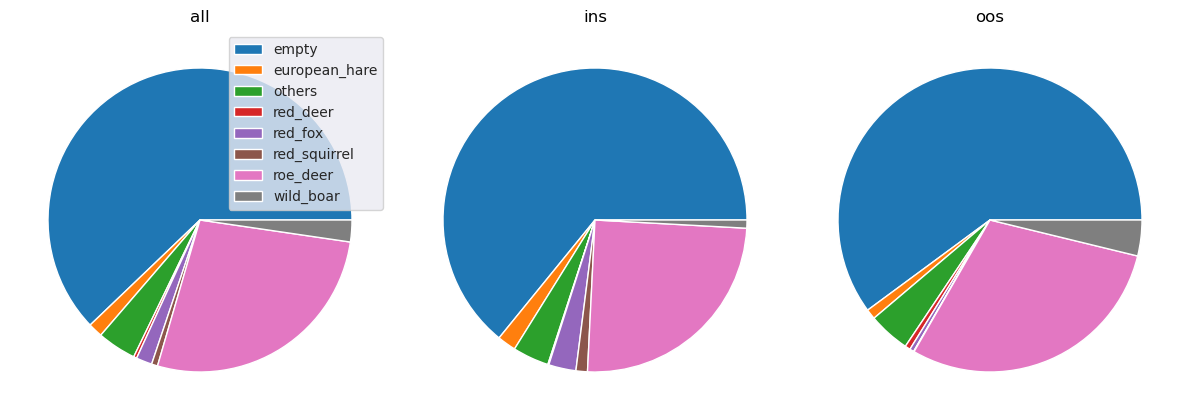

In [4]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(12,5),  tight_layout=True)

for i, (title, df) in enumerate(zip(['all', 'ins', 'oos'], [df_meta, df_ins, df_oos])):
    rf.plot_frequencies(
        df=df, 
        labels=labels, 
        ax=ax[i],
    )
    ax[i].set_title(title)
ax[0].legend(labels, loc="best", fontsize=10)
plt.show()
plt.close()

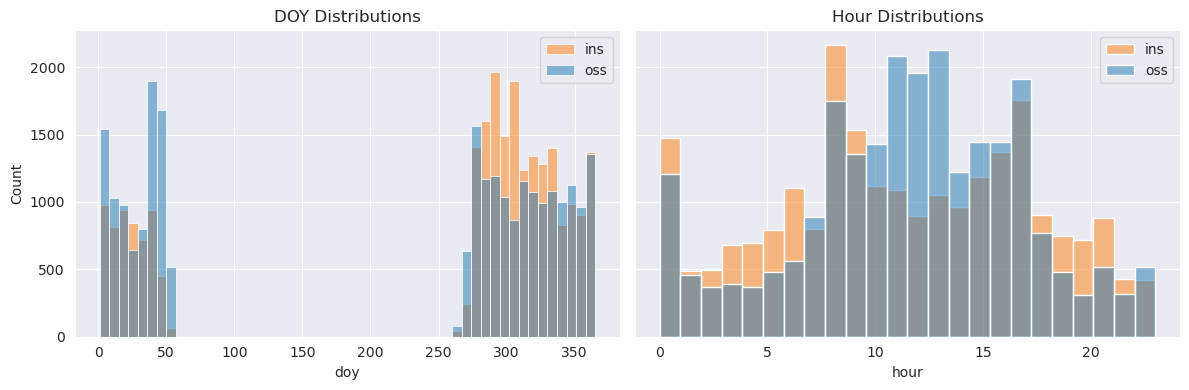

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True, tight_layout=True)
sns.histplot(data=df_meta, x='doy', hue='station_set', hue_order=['s1', 's2'], ax=ax[0], bins=52)
ax[0].legend(['ins', 'oss'], loc="best", fontsize=10)
ax[0].set_title('DOY Distributions')

sns.histplot(data=df_meta, x='hour', hue='station_set', hue_order=['s1', 's2'], ax=ax[1], bins=24)
ax[1].legend(['ins', 'oss'], loc="best", fontsize=10)
ax[1].set_title('Hour Distributions')
plt.show()

# IN-SAMPLE

In [6]:
eval_details_path = 'results/202211251613_details_insample_perf.pkl'
eval_details_dict = load_pickle(eval_details_path)

df_pred = rf.build_df_pred(eval_details_dict, label_dict, detector_dict, image_data_dir)
df_pred = rf.labelize_df_pred(df_pred, translator_dict)
df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
pref_dict = rf.evaluate_performance(df_pred['true_class'], df_pred['pred_class'], labels, average='macro',)

macro_perf_ins = {metric: pref_dict[metric] for metric in metrics}
print(macro_perf_ins)

{'acc': 0.8843967150979154, 'prec': 0.869295009617693, 'rec': 0.7694201742279487, 'f1': 0.812167083286727}


               precision    recall  f1-score   support

        empty       0.87      0.90      0.88       347
european_hare       0.84      0.78      0.81        65
       others       0.61      0.59      0.60       112
     red_deer       1.00      0.67      0.80         3
      red_fox       0.90      0.77      0.83        95
 red_squirrel       0.91      0.81      0.86        48
     roe_deer       0.92      0.95      0.93       884
    wild_boar       0.91      0.69      0.78        29

     accuracy                           0.88      1583
    macro avg       0.87      0.77      0.81      1583
 weighted avg       0.88      0.88      0.88      1583



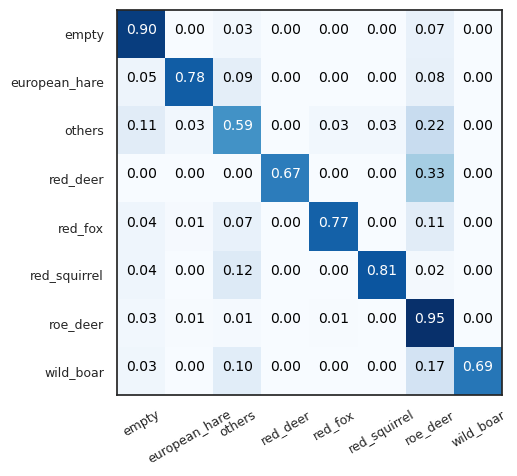

In [7]:
#_paper_

# Table: confusion matrix and recall/precision
report = classification_report(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=list(translator_dict.values()),
    zero_division=0,
    output_dict=False,
)
print(report)

rf.inspect_confusion(
    df_pred=df_pred, 
    normalize=True, 
    labels=labels, 
    ax=None,
)

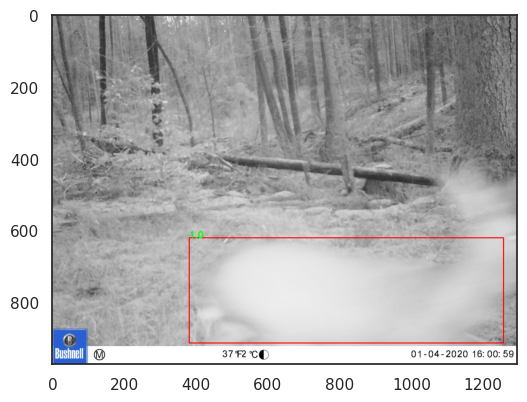

img_name:      11611_01040340.JPG
true_class:    empty
pred_class:    others
pred_score:    0.997
n_preds:       1
pred_classes:  ['others']
pred_confs:    [0.998]
md_confs:      [1.0]
score_dict:    {'others': 0.997, 'roe_deer': 0.002, 'empty': 0.0, 'european_hare': 0.0, 'red_deer': 0.0, 'red_fox': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


In [8]:
#_paper_

# Perhaps show some missclassified images
rf.inspect_misclasses(
    df_pred=df_pred, 
    test_label='empty', 
    translator_dict=translator_dict,
    n_displays=1, 
    descending=True, 
    is_truth=True,
)


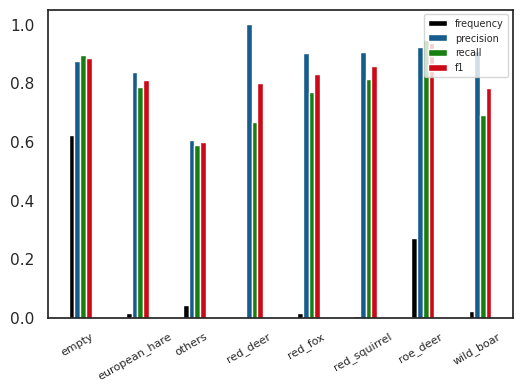

In [9]:
rf.plot_class_performance(
    df_pred=df_pred, 
    df_meta=df_meta, 
    labels=labels, 
    ax=None)

# EMPTY VS NON-EMPTY

In [10]:
#eval_results_path = 'results/202211181014_results_insample_empty.json'
#eval_details_path = 'results/202211181014_details_insample_empty.pkl'
eval_results_path = 'results/202211251652_results_insample_empty.json'
eval_details_path = 'results/202211251652_details_insample_empty.pkl'

eval_results_dict = load_json(eval_results_path)
eval_details_dict = load_pickle(eval_details_path)
df = pd.DataFrame(eval_results_dict)

for index_tresh in range(3):
    threshold = df.loc[index_tresh, 'thresholds']
    df_pred = rf.build_df_pred(eval_details_dict[threshold], label_dict, detector_dict, image_data_dir)
    df_pred = rf.labelize_df_pred(df_pred, translator_dict)
    df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
    
    # performance on binary classification
    pref_b = rf.evaluate_performance(
        y_true=df_pred['true_class'].map(map_dict), 
        y_pred=df_pred['pred_class'].map(map_dict), 
        labels=['non_empty', 'empty'], 
        average=None,
    )
    
    # performance on multiclass classification
    pref_m = rf.evaluate_performance(
        y_true=df_pred['true_class'], 
        y_pred=df_pred['pred_class'], 
        labels=list(translator_dict.values()), 
        average='macro',
    )
    
    df.loc[index_tresh, 'acc_b'] = pref_b['acc']
    df.loc[index_tresh, 'prec_b'] = pref_b['prec'][0]
    df.loc[index_tresh, 'rec_b'] = pref_b['rec'][0]
    df.loc[index_tresh, 'f1_b'] = pref_b['f1'][0]
    
    df.loc[index_tresh, 'acc_m'] = pref_m['acc']
    df.loc[index_tresh, 'prec_m'] = pref_m['prec']
    df.loc[index_tresh, 'rec_m'] = pref_m['rec']
    df.loc[index_tresh, 'f1_m'] = pref_m['f1']

#_paper_
#Table: rates for 3 different thresholds: ours, 0.5, 0.9

df

,names,thresholds,tnr_md,tpr_md,fnr_md,fpr_md,tnr_ppl,tpr_ppl,fnr_ppl,fpr_ppl,acc_b,prec_b,rec_b,f1_b,acc_m,prec_m,rec_m,f1_m
0,ours,0.1,0.0000,1.0000,0.0000,1.0000,0.8069,0.9830,0.0170,0.1931,0.944409,0.947738,0.983010,0.965052,0.876816,0.873429,0.755143,0.805069
1,progressive,0.5,0.5573,0.8795,0.1205,0.4427,0.9078,0.9668,0.0332,0.0922,0.953885,0.973920,0.966828,0.970361,0.899558,0.880515,0.807944,0.836943
2,norouzzadeh,0.9,0.7514,0.8452,0.1548,0.2486,0.9280,0.9401,0.0599,0.0720,0.937461,0.978939,0.940129,0.959142,0.869867,0.699279,0.676959,0.686165


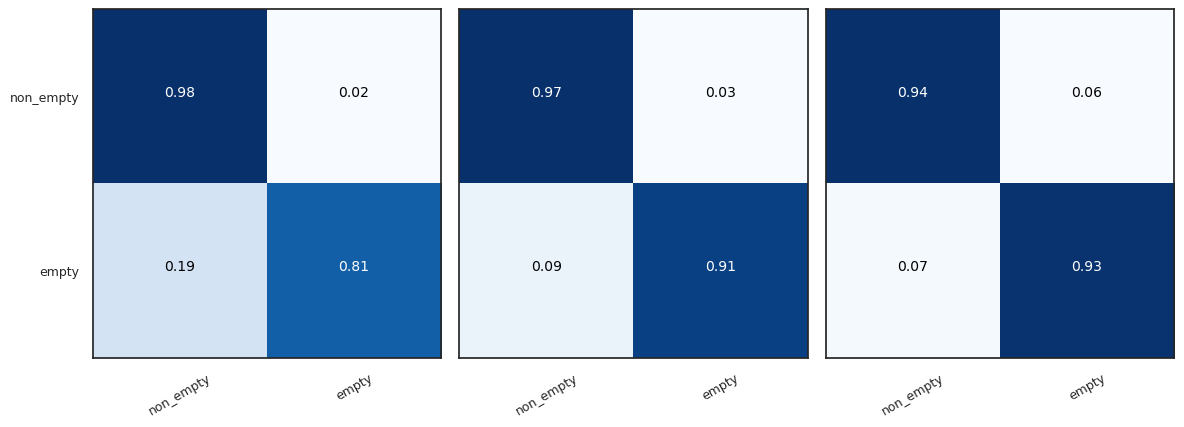

In [11]:
fig, ax = plt.subplots(1,3, figsize=(12, 6), tight_layout=True, sharey=True)

for index_tresh in range(3):
    threshold = df.loc[index_tresh, 'thresholds']
    df_pred = rf.build_df_pred(eval_details_dict[threshold], label_dict, detector_dict, image_data_dir)
    df_pred = rf.labelize_df_pred(df_pred, translator_dict)
    df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
    df_pred['true_class'] = df_pred['true_class'].map(map_dict)
    df_pred['pred_class'] = df_pred['pred_class'].map(map_dict)
    
    rf.inspect_confusion(
        df_pred=df_pred, 
        normalize=True, 
        labels=['non_empty', 'empty'], 
        ax=ax[index_tresh])

plt.show()
plt.close()

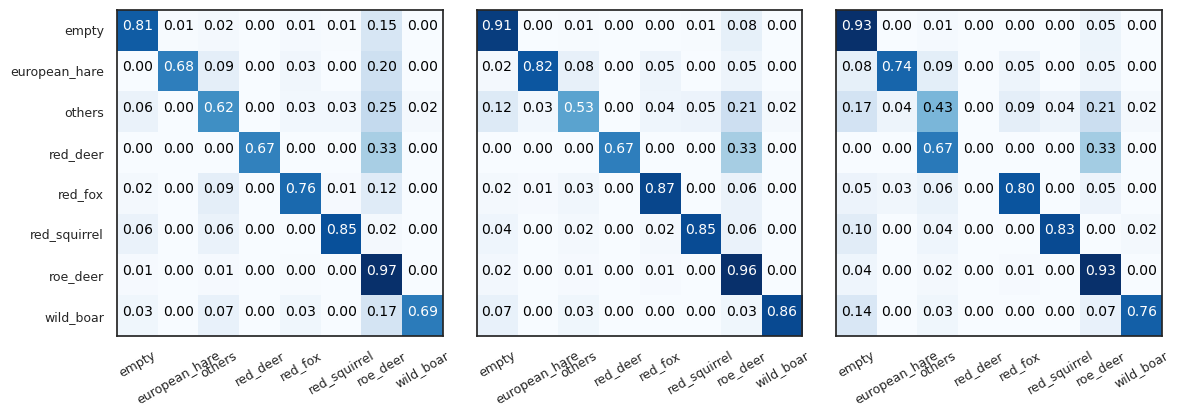

In [12]:
fig, ax = plt.subplots(1,3, figsize=(12, 6), tight_layout=True, sharey=True)

for index_tresh in range(3):
    threshold = df.loc[index_tresh, 'thresholds']
    df_pred = rf.build_df_pred(eval_details_dict[threshold], label_dict, detector_dict, image_data_dir)
    df_pred = rf.labelize_df_pred(df_pred, translator_dict)
    df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
    
    rf.inspect_confusion(
        df_pred=df_pred, 
        normalize=True, 
        labels=list(translator_dict.values()), 
        ax=ax[index_tresh])

plt.show()
plt.close()

In [13]:
#_paper_

#XX% of empty images are correctly detected (TN) 
#only XX% are falsely labeled as empty where in fact they contain animals (FN)
TN = df.loc[0, 'tnr_ppl'] 
FN = df.loc[0, 'fnr_ppl']
print(f'{TN}% of empty images are correctly detected')
print(f'{FN}% are falsely labeled as empty')

0.8069% of empty images are correctly detected
0.0170% are falsely labeled as empty


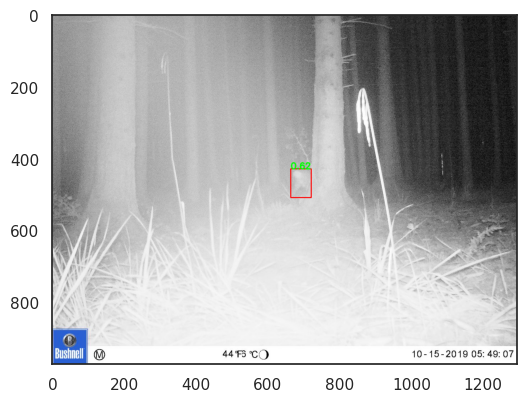

img_name:      108623_10150174.JPG
true_class:    roe_deer
pred_class:    empty
pred_score:    0.622
n_preds:       1
pred_classes:  ['empty']
pred_confs:    [1.0]
md_confs:      [0.62]
score_dict:    {'empty': 0.622, 'european_hare': 0.0, 'others': 0.0, 'red_deer': 0.0, 'red_fox': 0.0, 'red_squirrel': 0.0, 'roe_deer': 0.0, 'wild_boar': 0.0}


In [14]:
#_paper_

#Figure: some false non-empties
rf.inspect_misclasses(
    df_pred=df_pred, 
    test_label='empty', 
    translator_dict=translator_dict,
    n_displays=1, 
    descending=True, 
    is_truth=False,
)

# OUT-OF-SAMPLE

In [15]:
eval_details_path = 'results/202211251804_details_oosample_perf.pkl'
eval_details_dict = load_pickle(eval_details_path)

df_pred = rf.build_df_pred(eval_details_dict, label_dict, detector_dict, image_data_dir)
df_pred = rf.labelize_df_pred(df_pred, translator_dict)
df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')

pref_dict = rf.evaluate_performance(df_pred['true_class'], df_pred['pred_class'], labels, average='macro',)
macro_perf_oos = {metric: pref_dict[metric] for metric in metrics}
print(macro_perf_oos)

{'acc': 0.7815126050420168, 'prec': 0.5107573179633147, 'rec': 0.5467491889462164, 'f1': 0.5079510370781017}


               precision    recall  f1-score   support

        empty       0.84      0.62      0.71       320
european_hare       0.66      0.56      0.61        41
       others       0.32      0.39      0.35       104
     red_deer       0.00      0.00      0.00        21
      red_fox       0.35      0.46      0.40        13
 red_squirrel       0.25      0.75      0.38         4
     roe_deer       0.83      0.91      0.87      1040
    wild_boar       0.84      0.67      0.75       123

     accuracy                           0.78      1666
    macro avg       0.51      0.55      0.51      1666
 weighted avg       0.78      0.78      0.78      1666



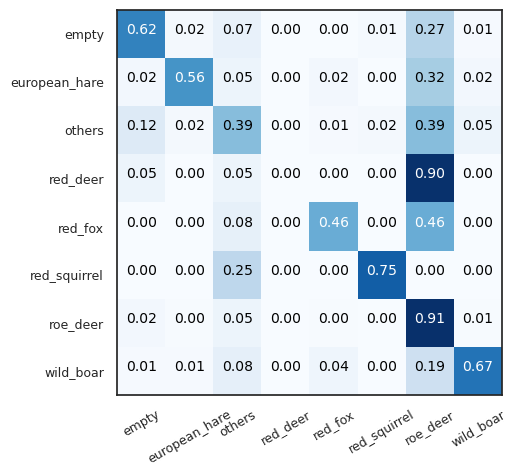

In [16]:
#_paper_

# Table: OOS performance 
report = classification_report(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=list(translator_dict.values()),
    zero_division=0,
    output_dict=False,
)
print(report)

rf.inspect_confusion(
    df_pred=df_pred, 
    normalize=True, 
    labels=labels, 
    ax=None,
)

In [17]:
#_paper_
# Table: compare INS va. OOS (macro averages)

df = pd.DataFrame(index=metrics)
df['ins']= macro_perf_ins.values()
df['oos']= macro_perf_oos.values()
df

,ins,oos
acc,0.884397,0.781513
prec,0.869295,0.510757
rec,0.769420,0.546749
f1,0.812167,0.507951
